In [1]:
from pairs_helper_functions import *


In [70]:
def scale_size(total_size:float, num_orders:int):
    step = total_size / num_orders * 1.725
    prices = list()
    for i in range(num_orders):
        value = step + i*step
        prices.append(value)
        step -= step/num_orders
    return prices
a = scale_size(10,20)
print(a)
print(sum(a))

[0.8625, 1.6387500000000002, 2.33521875, 2.95794375, 3.5125582031250002, 4.0043163515625, 4.438117289648438, 4.818527343046875, 5.1498010978813475, 5.4359011588747554, 5.6805167110241195, 5.88708095506136, 6.058787482917316, 6.198605655600023, 6.309295042307167, 6.393418976204596, 6.453357279106514, 6.491318204277729, 6.509349643734056, 6.509349643734056]
97.64471353810586


In [4]:
import ccxt
ftx =  ccxt.ftx({
                            'apiKey': "b2aqGzkAAbBrs8qxEVswYZNbMCLmCeV_MeJhT8-e",
                            'secret': "FTgEkFA3MHIANWYZ_qMinrkzN-wmEQ4xg4jlcXFN",
                            'hostname': 'ftx.us',
                            'name': 'FTXUS',
                            'enableRateLimit': True,
                        })

In [155]:
markets = {"SOL": -.3, "ETH":.5, "BTC":.5, "AVAX":-.7}

In [156]:
last_prices = dict()
for i in markets.keys():
    s = i + "/USD:USD"
    last = markets.query("symbol == @s")
    print(last['info'])
    # last_prices[last['name']] = (last['last'], last['minProvideSize'])

AttributeError: 'dict' object has no attribute 'query'

In [149]:
a = pd.DataFrame(o.ftx.fetch_balance()['info']['result'])


In [ ]:
import pandas as pd
from oms import OMS
import time


o = OMS()
def balance():
    df = pd.DataFrame(o.ftx.fetch_balance()['info']['result'])
    sum = 0
    for i in df['usdValue']:
        sum += float(i)
    return sum

def last_prices():
    mkts = pd.DataFrame(o.ftx.fetch_markets())
    last_prices = dict()
    for i in markets.keys():
        s = i + "/USD:USD"
        last = mkts.query("symbol == @s")['info'].iloc[0]
        last_prices[i] = (last['last'], last['minProvideSize'])
    return last_prices

# get balance * lev -> multiply by weights to get dollar value/token
# calc amount to purchase
pos = o.positions()
print(pos)
markets = {"GAL": -.5, "UST":-.5}
# pos = o.positions()
lev = 2
lp = last_prices()
value = balance()
size = dict()
acc_val = balance()

curr_lev = pos['notional'].sum() / acc_val

net_lev = 0.0
for i in pos.iterrows():
    if i[1]['side'] == "short":
        net_lev -= i[1]['notional'] / value
    else:
        net_lev += i[1]['notional'] / value

    

print(net_lev)

# calculate desired size
for k,v in markets.items():
    notional = v*value*lev
    amt = notional / float(lp[k][0])
    sz = int(amt / float(lp[k][1])) * float(lp[k][1])
    size[k] = sz

sz_pd = pd.DataFrame([[k,v] for k,v in size.items()], columns=["ticker","size"])
print(curr_lev)

def size(row):
    if row['side'] == "short":
        return -row['contracts']
    else:
        return row['contracts']

def rm_suffix(row):
    return row['symbol'].removesuffix("/USD:USD")
    

pos['current_size'] = pos.apply (lambda row: size(row), axis=1)

pos['ticker'] = pos.apply (lambda row: rm_suffix(row), axis=1)

# sz_pd['current_size'] = pos['contracts'] if pos['side'] == "long" else -pos['contracts']
curr = pd.DataFrame()
curr['curr_size'] = pos.apply (lambda row: size(row), axis=1)
curr['ticker'] = pos.apply (lambda row: rm_suffix(row), axis=1)



# sz_pd['order_size'] = sz_pd['size'] - sz_pd['current_size']

final = pd.merge(sz_pd, curr, on="ticker", how="left").fillna(0)
final['diff'] = final['size'] - final['curr_size']
print(final)
# o.twap_df(final)
# print(pos.apply (lambda row: size(row), axis=1))
    






In [54]:
import pandas as pd
from oms import OMS
import time
o = OMS()
def last_prices(markets):
    mkts = pd.DataFrame(o.ftx.fetch_markets())
    last_prices = dict()
    for i in markets:
        s = i + "/USD:USD"
        last = mkts.query("symbol == @s")['info'].iloc[0]
        last_prices[i] = (last['last'], last['minProvideSize'])
    return last_prices
    
last_prices(["SOL","ETH","BTC"])

{'SOL': ('50.5375', '0.01'),
 'ETH': ('1978.5', '0.001'),
 'BTC': ('29463.0', '0.001')}

min drawdown: -136.49%
max return: -82.19%
current return: -129.33%
BTC : 0.7
ETH : 0.3


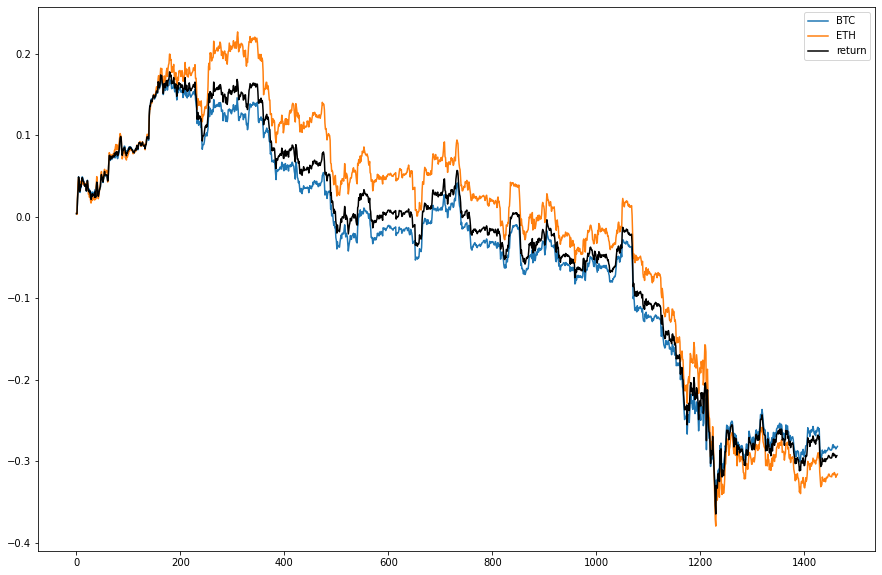

In [49]:
a,market_returns,pct = multi_weighted_index({"BTC":.7,"ETH":.3}, 60, resolution="1h")
# b,mrk, pct_s = multi_weighted_index({"NEAR":-.25,"SOL":-.25, "AVAX":-.25,"ATOM":-.25}, 30, resolution="1h")

In [47]:
t = get_historical_data("2022-03-21", "SOL-PERP", "1h")


In [58]:
len(pct), len(t[:1464])

(1464, 1464)

<AxesSubplot:>

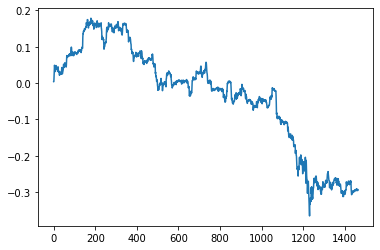

In [71]:
t_df = pd.DataFrame(t[:1464], columns=["time", "open" ,"high", "low", "close","volume"])
t_df['returns'] = (t_df['close'] - t_df['close'][0]) / t_df['close'][0]

bdf = pd.DataFrame(columns=["market","ticker"])
bdf["ticker"] = t_df['returns']
bdf["market"] = pct

def calc_beta(df):
    np_array = df.values
    s = np_array[:,0] 
    m = np_array[:,1]

    covariance = np.cov(s,m) 
    beta = covariance[0,1]/covariance[1,1]
    return beta

def rolling(df, period, function , min_periods=None):
    if min_periods is None:
        min_periods = period
    result = pd.Series(np.nan, index=df.index)

    for i in range(1, len(df)+1):
        df2 = df.iloc[max(i-period, 0):i,:] #I edited here
        if len(df2) >= min_periods:
            idx = df2.index[-1]
            result[idx] = function(df2)
    return result

bdf['beta'] = rolling(bdf, 4, calc_beta, min_periods=None)
bdf['market'].plot()


In [75]:
bdf['index'] = bdf["market"] - bdf["ticker"]
bdf['beta'].mean()

-0.03637901699864904

<AxesSubplot:>

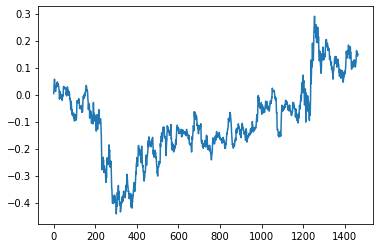

In [64]:
bdf['index'].plot()

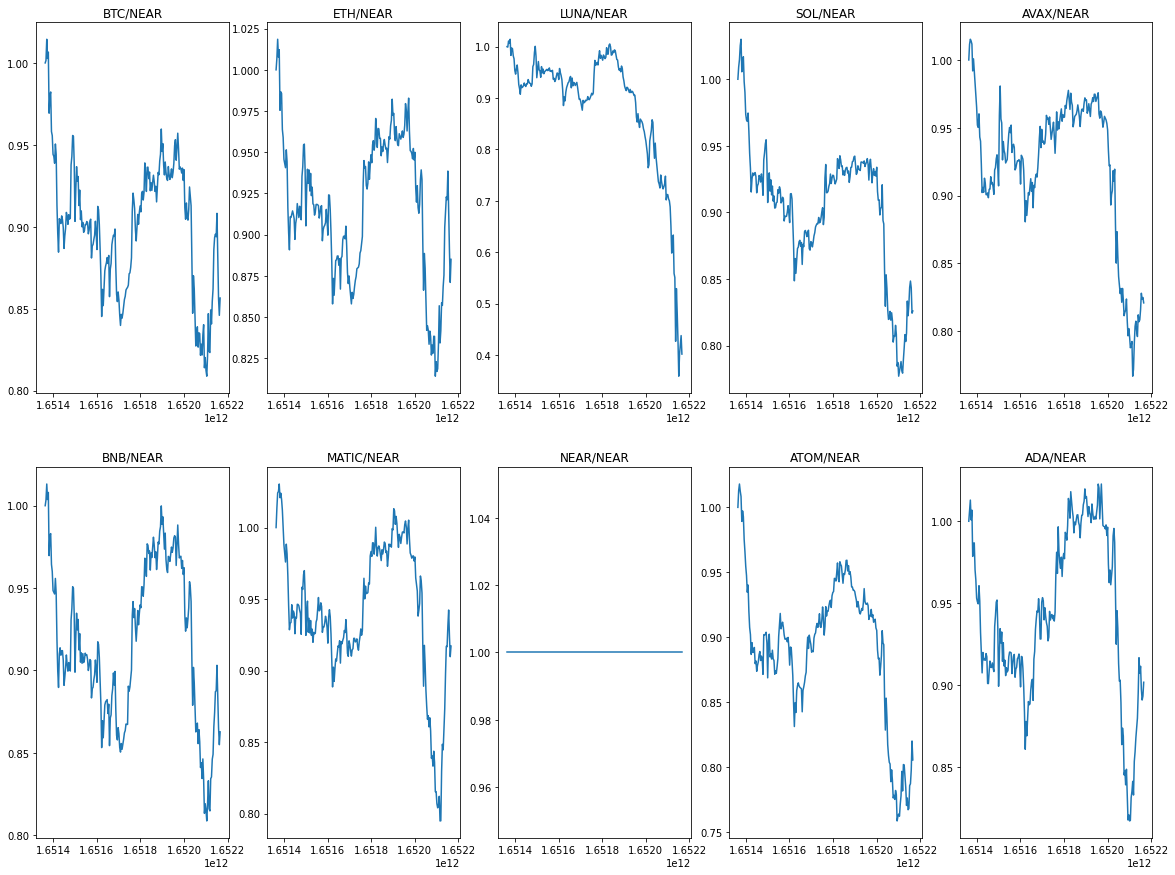

In [14]:
a= compare("2022-05-01", "NEAR-PERP" , long=False)

In [ ]:
import ccxt
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.options.plotting.backend = "plotly"
ftx =  ccxt.ftx({
                            'apiKey': os.getenv('API_KEY'),
                            'secret': os.getenv('API_SECRET'),
                        })

positions = pd.DataFrame(ftx.fetch_positions())
# positions[['symbol','notional',
#            'unrealizedPnl','contracts',
#            'markPrice', 'percentage', 'liquidationPrice',
#            'side',
#           ]]


: 

In [2]:
from termcolor import colored
p = positions[positions['notional'] > 0][['symbol','notional','side','contracts']]
total = p['notional'].sum()
p['weight'] = round(p['notional'] / total * 100,2)
print(colored("hi"), "cyan")
for i in p.sort_values(by=["weight"]).iterrows():
    print(f"{i[1]['symbol'].removesuffix('/USD:USD')} {i[1]['side']} {i[1]['contracts']} contracts ({i[1]['notional']}$) weight: {i[1]['weight']}")

NameError: name 'positions' is not defined

In [36]:
import pandas as pd
df = pd.read_csv("../data/Binance_ETHUSDT_1h.csv")

In [68]:
import pandas_ta as ta
import plotly.express as px


In [49]:
df = df[df['date'] > "2020-01-01"]
df['hma_200'] = df.ta.hma(length=200)

/var/folders/x4/v6qr377j3bbc576wq6903mvm0000gn/T/ipykernel_7073/2608586351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hma_200'] = df.ta.hma(length=200)


In [82]:
data = df[212:]
data['pct_dev'] = round(100*((data['hma_200'] - data['close']) / data['close'] ),4)


/var/folders/x4/v6qr377j3bbc576wq6903mvm0000gn/T/ipykernel_7073/57468003.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,hma_200,pct_dev
212,1.650773e+12,2022-04-24 04:00:00,ETH/USDT,2955.93,2958.85,2948.62,2951.22,5937.2522,1.754233e+07,10974.0,2932.351310,-0.6394
213,1.650769e+12,2022-04-24 03:00:00,ETH/USDT,2932.34,2960.00,2930.01,2955.92,10693.1294,3.153426e+07,17028.0,2933.264941,-0.7664
214,1.650766e+12,2022-04-24 02:00:00,ETH/USDT,2928.01,2939.54,2922.77,2932.35,7467.4838,2.189809e+07,13130.0,2934.120668,0.0604
215,1.650762e+12,2022-04-24 01:00:00,ETH/USDT,2935.74,2942.49,2928.00,2928.01,8482.2448,2.490662e+07,13327.0,2934.902416,0.2354
216,1.650758e+12,2022-04-24 00:00:00,ETH/USDT,2933.04,2945.73,2930.40,2935.74,9451.5633,2.777303e+07,15840.0,2935.644091,-0.0033
...,...,...,...,...,...,...,...,...,...,...,...,...
20451,1.577851e+09,2020-01-01 04-AM,ETH/USDT,130.20,130.74,130.15,130.20,3347.0900,4.363809e+05,NaN,127.890402,-1.7739
20452,1.577848e+09,2020-01-01 03-AM,ETH/USDT,130.85,130.89,129.94,130.20,4691.4500,6.112795e+05,NaN,127.896096,-1.7695
20453,1.577844e+09,2020-01-01 02-AM,ETH/USDT,130.64,130.98,130.35,130.85,7500.5700,9.805787e+05,NaN,127.903092,-2.2521
20454,1.577840e+09,2020-01-01 01-AM,ETH/USDT,128.87,130.65,128.78,130.64,11128.4800,1.446168e+06,NaN,127.911104,-2.0889


In [87]:
print(f"mean of : {data['pct_dev'].mean()}")
print(f"std of : {data['pct_dev'].std()}")
sd_3 = data[abs(data['pct_dev']) > 13.5]

mean of : 0.0753152637818613
std of : 4.505967800252646


In [88]:
sd_3

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,hma_200,pct_dev
1523,1.646053e+12,2022-02-28 13:00:00,ETH/USDT,2635.17,2640.66,2607.38,2617.56,19329.1270,5.070913e+07,33441.0,3010.124473,14.9973
1524,1.646050e+12,2022-02-28 12:00:00,ETH/USDT,2640.55,2665.79,2626.26,2635.17,22281.6042,5.899453e+07,37118.0,3005.630287,14.0583
1525,1.646046e+12,2022-02-28 11:00:00,ETH/USDT,2640.28,2646.97,2621.40,2640.54,10942.4077,2.885083e+07,21717.0,3000.400211,13.6283
1527,1.646039e+12,2022-02-28 09:00:00,ETH/USDT,2625.34,2642.58,2612.36,2612.39,13837.9246,3.641220e+07,28080.0,2987.984275,14.3774
1528,1.646035e+12,2022-02-28 08:00:00,ETH/USDT,2635.32,2658.00,2617.00,2625.34,19087.8620,5.032814e+07,36982.0,2980.936928,13.5448
...,...,...,...,...,...,...,...,...,...,...,...,...
19460,1.581419e+09,2020-02-11 11-AM,ETH/USDT,221.09,222.80,221.00,222.60,12281.4000,2.723713e+06,NaN,254.169108,14.1820
19461,1.581415e+09,2020-02-11 10-AM,ETH/USDT,221.23,222.20,220.31,221.09,12456.7500,2.756914e+06,NaN,253.054858,14.4578
19462,1.581412e+09,2020-02-11 09-AM,ETH/USDT,220.60,222.32,220.00,221.23,21006.5000,4.648261e+06,NaN,251.917242,13.8712
19463,1.581408e+09,2020-02-11 08-AM,ETH/USDT,218.61,220.60,218.23,220.60,14283.7700,3.130295e+06,NaN,250.759171,13.6714


In [ ]:
btc = get_historical_data("2021-01-01", "BTC-PERP", "1d")